This code inputs renormalized coarse-grained data (via a Lucy function), calculates the relevant COMPRESSIBLE velocity field data and then uses a least-squares fitting to minimize an error term incorporating 1. the unknown pressure and visosity fields 2. momentum conservation 3. pressure field smoothness $(\frac{\partial p}{\partial x})^2 + (\frac{\partial p}{\partial z})^2$ 4. viscous field smoothness $(\frac{\partial \nu}{\partial x})^2 + (\frac{\partial \nu}{\partial z})^2$ 5. a hydrostatic pressure model prior

In [502]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter
from scipy.interpolate import LinearNDInterpolator

In [503]:
def gaussian_smooth(u,nx,nz,sigma):
    return gaussian_filter(u.reshape((nx,nz)),sigma=sigma).reshape(u.shape)

In [504]:
def phi(X_i,X_j,a2):

    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            #r2 = (X_i[i,0] - X_j[j,0])**2 + (X_i[i,1] - X_j[j,1])**2
            #r = np.sqrt(r2)
            #phimat[i,j] = np.sqrt(1 + a2*r2)
            #phimat[i,j] = r**3*np.log(r**r)
            #phimat[i,j] = r**3
            phimat[i,j] = ((x_i - x_j)**2 + (z_i - z_j)**2)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    
    return phimat 

def nablaphi(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]

            phimat[i,j] = 16*(x_i - x_j)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 16*(x_i - x_j)**2 + 16*(z_i - z_j)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 16*(z_i - z_j)**2
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    return phimat 

def dphidx(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]

            phimat[i,j] = 2*(x_i - x_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    
    return phimat 

def dphidz(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]

            phimat[i,j] = 2*(z_i - z_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    
    return phimat 

def d2phidx2(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            phimat[i,j] = 14*(x_i - x_j)**2 + 2*(z_i - z_j)**2 + 4*(3*(x_i - x_j)**2 + (z_i - z_j)**2)*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0

    return phimat

def d2phidz2(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            phimat[i,j] = 2*(x_i - x_j)**2 + 14*(z_i - z_j)**2 + 4*((x_i - x_j)**2 + 3*(z_i - z_j)**2)*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0

    return phimat

def d2phidxdz(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            4*(x_i - x_j)*(z_i - z_j)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 3)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0

    return phimat

In [505]:
#numerical parameters
pi = 3.14159

In [506]:
#building grid:

RCG = '0_02'

#data = np.loadtxt('/home/bay22/git_repositories/RIMSAR/data/03_processed/renormalized_coarse_grain/RCG_c'+RCG+'.dat')
data = np.loadtxt('/home/bay22/git_repositories/RIMSAR/data/03_processed/coarse_grain/RCG_c'+RCG+'.dat')
#data = np.loadtxt('cavityNonNewtonian_n2_k0_01_0.csv',delimiter = ',')
plt.figure(figsize=(8,8))
u_data = data[:,3] 
v_data = -data[:,4]
rho_data = data[:,2]
Xu = data[:,0]
Zu = data[:,1]

#normalizing density:

rho_data /= np.max(rho_data)
#smoothing velocity data
#u_data = gaussian_filter(u_data.reshape((100,100)),sigma=5).flatten()
#v_data = gaussian_filter(v_data.reshape((100,100)),sigma=5).flatten()




<Figure size 576x576 with 0 Axes>

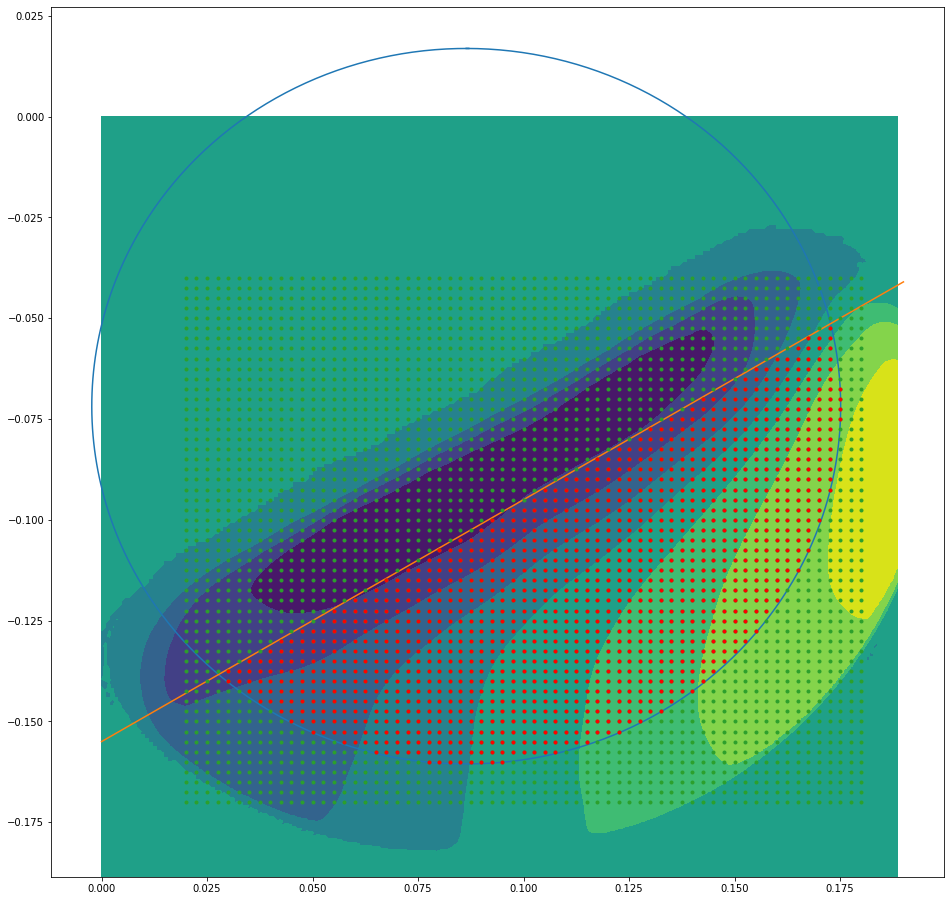

In [507]:
dx = 0.0025
xx,zz = np.meshgrid(np.arange(0.02,0.18+dx,dx),np.arange(-0.17,-0.04+dx,dx))
Xtotal = np.stack((xx.flatten(),zz.flatten()),axis=1)
nx = xx.shape[0]
nz = xx.shape[1]



#removing points outside of circle:
dt = 0.01



pixel2real = 0.0001848337
xc = 467.5*pixel2real
zc = 388.6*pixel2real
#r = 524.8*pixel2real #true radius
r = 480*pixel2real
theta = np.arange(0,2*3.14159+dt,dt)
xcircle = xc + r*np.sin(theta)
zcircle = -zc + r*np.cos(theta)
xline = np.arange(0,0.2,0.01)
m = 0.6
c = -0.155
yline = xline*m + c
X_interior = Xtotal[Xtotal[:,1]-m*Xtotal[:,0]-c<=0,:]
X_interior = X_interior[(X_interior[:,0]-xc)**2 + (X_interior[:,1]+zc)**2 - r**2 <= 0,:]

interior_index0 = np.argwhere(Xtotal[:,1]-m*Xtotal[:,0]-c<=0)
interior_index1 = np.argwhere((Xtotal[:,0]-xc)**2 + (Xtotal[:,1]+zc)**2 - r**2 <= 0) 

interior_index = np.intersect1d(interior_index0,interior_index1)
X_interior = Xtotal[interior_index,:]


plt.figure(figsize=(16,16))
#plt.tricontourf(Xu,Zu,np.sqrt(u_data**2 + v_data**2))
plt.tricontourf(Xu,Zu,v_data)
plt.plot(xcircle,zcircle)
plt.plot(xline,yline)
plt.plot(xx.flatten(),zz.flatten(),'.')
plt.plot(X_interior[:,0],X_interior[:,1],'.',color = 'r')
X = X_interior + 0


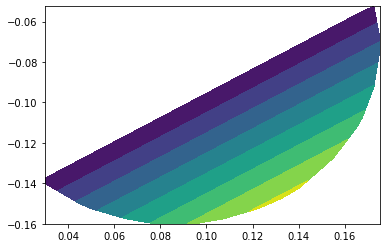

In [508]:
#finding nnearest neighbours of each point in Xj
r2 = (X[:,0:1]-X[:,0:1].transpose())**2 + (X[:,1:2]-X[:,1:2].transpose())**2

X_neighbours = np.zeros((X.shape[0],9),dtype = int)

X_neighbours = np.zeros((X.shape[0],9),dtype = int)
for i in range(0,X.shape[0]):
    X_neighbours[i,:] = (np.argpartition(r2[:,i],9)[0:9])


u_interp = LinearNDInterpolator(list(zip(Xu,Zu)), u_data)
v_interp = LinearNDInterpolator(list(zip(Xu,Zu)), v_data)
rho_interp = LinearNDInterpolator(list(zip(Xu,Zu)), rho_data)

u_test = u_interp(Xtotal[:,0:1],Xtotal[:,1:2])
v_test = v_interp(Xtotal[:,0:1],Xtotal[:,1:2])
rho_test = rho_interp(Xtotal[:,0:1],Xtotal[:,1:2])

u_test[np.isnan(u_test)] = 0
v_test[np.isnan(v_test)] = 0
rho_test[np.isnan(rho_test)] = 0


plt.tricontourf(X_interior[:,0],X_interior[:,1],X_interior[:,0]*m+c-X_interior[:,1])

In [509]:
#calculating velocity derivatives:

recalculate_velocity = False

if recalculate_velocity:
    phi_matu = phi(Xtotal,Xtotal,0)
    dphidx_matu = dphidx(Xtotal,Xtotal,0)
    dphidz_matu = dphidz(Xtotal,Xtotal,0)
    d2phidxdz_matu = d2phidxdz(Xtotal,Xtotal,0)
    d2phidx2_matu = d2phidx2(Xtotal,Xtotal,0)
    d2phidz2_matu = d2phidz2(Xtotal,Xtotal,0)

    #in velocity space:
    phi_invu = np.linalg.inv(phi_matu)
    dphidx_matu = np.matmul(dphidx_matu,phi_invu)
    dphidz_matu = np.matmul(dphidz_matu,phi_invu)
    d2phidx2_matu = np.matmul(d2phidx2_matu,phi_invu)
    d2phidz2_matu = np.matmul(d2phidz2_matu,phi_invu)
    d2phidxdz_matu = np.matmul(d2phidxdz_matu,phi_invu)
    nabla2_matu = d2phidx2_matu + d2phidz2_matu





In [510]:
dphidx_matu.shape 

(3445, 3445)

In [511]:
#smoothing factor
sigma = 0
dsigma = 2
d2sigma = 2

u_test = gaussian_smooth(u_test,nx,nz,sigma)
v_test = gaussian_smooth(v_test,nx,nz,sigma)
rho_test = gaussian_smooth(rho_test,nx,nz,sigma)

#velocity fields:
u = np.diag(u_test[interior_index,0])
v = np.diag(v_test[interior_index,0])
rho = np.diag(rho_test[interior_index,0])

dpuudx = np.diag(gaussian_smooth(np.matmul(dphidx_matu,u_test*u_test*rho_test),nx,nz,dsigma)[interior_index,0] )
dpuvdz = np.diag(gaussian_smooth(np.matmul(dphidz_matu,u_test*v_test*rho_test),nx,nz,dsigma)[interior_index,0] )
dpuvdx = np.diag(gaussian_smooth(np.matmul(dphidx_matu,u_test*v_test*rho_test),nx,nz,dsigma)[interior_index,0] )
dpvvdz = np.diag(gaussian_smooth(np.matmul(dphidx_matu,u_test*v_test*rho_test),nx,nz,dsigma)[interior_index,0] )


dudz = np.diag(gaussian_smooth(np.matmul(dphidz_matu,u_test),nx,nz,dsigma)[interior_index,0] )
dudztest = gaussian_smooth(np.matmul(dphidz_matu,u_test),nx,nz,dsigma)[:,0]
dudx = np.diag(gaussian_smooth(np.matmul(dphidx_matu,u_test),nx,nz,dsigma)[interior_index,0])
d2udx2 = np.diag(gaussian_smooth(np.matmul(d2phidx2_matu,u_test),nx,nz,d2sigma)[interior_index,0])
d2udz2 = np.diag(gaussian_smooth(np.matmul(d2phidz2_matu,u_test),nx,nz,d2sigma)[interior_index,0])
d2udxdz = np.diag(gaussian_smooth(np.matmul(d2phidxdz_matu,u_test),nx,nz,d2sigma)[interior_index,0])

dvdz = np.diag(gaussian_smooth(np.matmul(dphidz_matu,v_test),nx,nz,dsigma)[interior_index,0])
dvdx = np.diag(gaussian_smooth(np.matmul(dphidx_matu,v_test),nx,nz,dsigma)[interior_index,0])
d2vdx2 = np.diag(gaussian_smooth(np.matmul(d2phidx2_matu,v_test),nx,nz,d2sigma)[interior_index,0])
d2vdz2 = np.diag(gaussian_smooth(np.matmul(d2phidz2_matu,v_test),nx,nz,d2sigma)[interior_index,0])
d2vdxdz = np.diag(gaussian_smooth(np.matmul(d2phidxdz_matu,v_test),nx,nz,d2sigma)[interior_index,0])

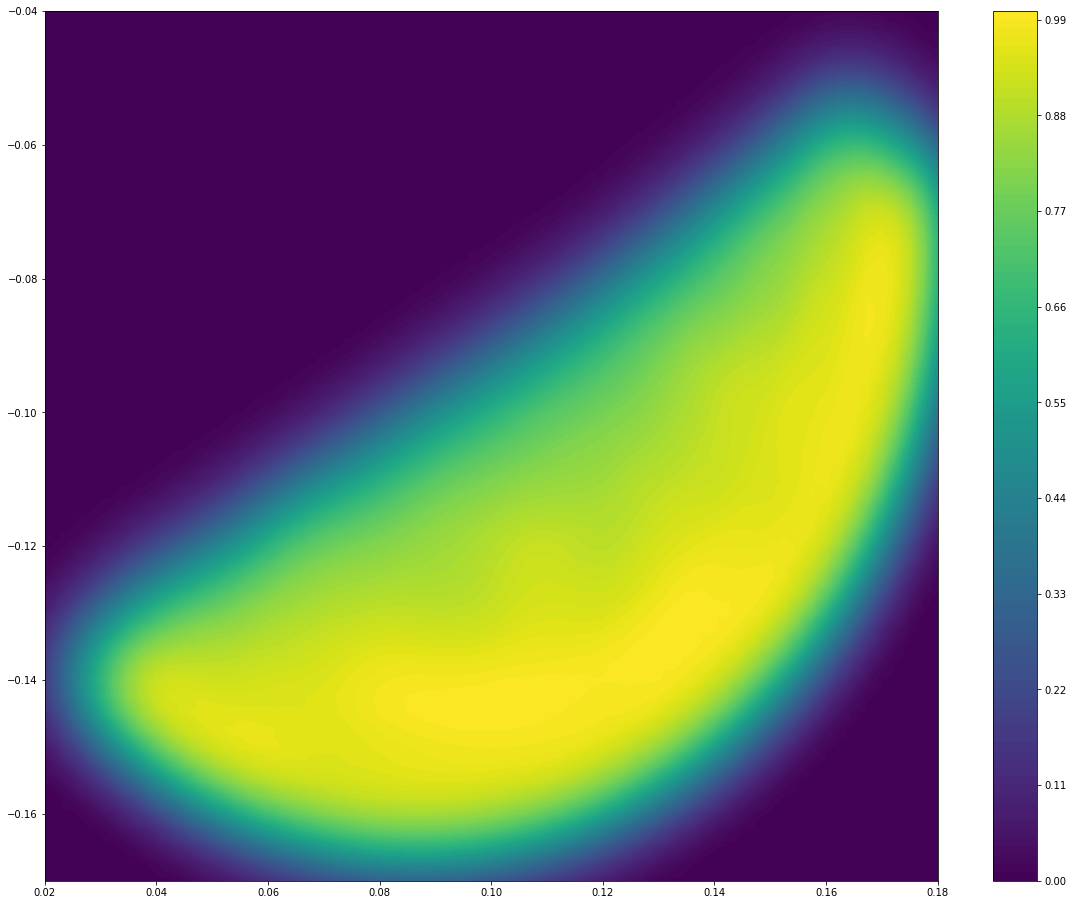

In [512]:
plt.figure(figsize = (20,16))
plt.tricontourf(Xtotal[:,0],Xtotal[:,1],rho_test[:,0],levels=100)
plt.colorbar()


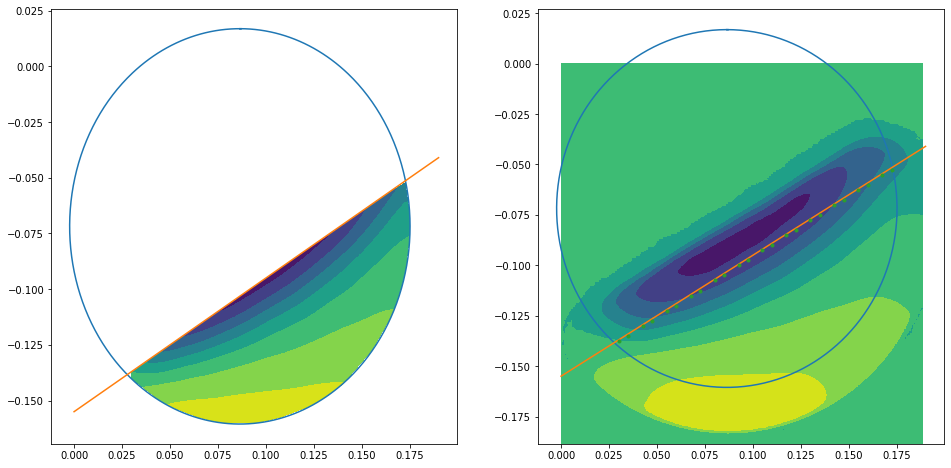

In [513]:
#building velocity derivatives
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.tricontourf(X_interior[:,0],X_interior[:,1],np.diag(u))
plt.plot(xcircle,zcircle)
plt.plot(xline,yline)
plt.subplot(1,2,2)
plt.tricontourf(Xu,Zu,u_data)
plt.plot(xcircle,zcircle)
plt.plot(xline,yline)

#finding points close to the line:

surface_point_index = np.argwhere(X_interior[:,0]*m+c-X_interior[:,1]-0.5*dx<0)[:,0]
X_surface = X_interior[surface_point_index,:]
plt.plot(X_surface[:,0],X_surface[:,1],'.')
#print(surface_point_index)

In [514]:
if False:

    phi_mat = phi(X_interior,X_interior,0)
    dphidx_mat = dphidx(X_interior,X_interior,0)
    dphidz_mat = dphidz(X_interior,X_interior,0)
    d2phidxdz_mat = d2phidxdz(X_interior,X_interior,0)
    d2phidx2_mat = d2phidx2(X_interior,X_interior,0)
    d2phidz2_mat = d2phidz2(X_interior,X_interior,0)

    #in velocity space:
    phi_inv = np.linalg.inv(phi_mat)
    dphidx_mat = np.matmul(dphidx_mat,phi_inv)
    dphidz_mat = np.matmul(dphidz_mat,phi_inv)
    d2phidx2_mat = np.matmul(d2phidx2_mat,phi_inv)
    d2phidz2_mat = np.matmul(d2phidz2_mat,phi_inv)
    d2phidxdz_mat = np.matmul(d2phidxdz_mat,phi_inv)
    nabla2_mat = d2phidx2_mat + d2phidz2_mat

In [515]:
N = phi_mat.shape[0]
phi_mat = np.eye(phi_mat.shape[0])
gov_mat = np.zeros((2*N,2*N))

#horizontal momentum:

#viscosity terms
gov_mat[0:N,0:N] =  2*np.matmul(dudx,dphidx_mat) + 2*np.matmul(d2udx2,phi_mat) + np.matmul(dudz + dvdx,dphidz_mat) + np.matmul(d2udz2+d2vdxdz,phi_mat) 

#compressible terms

gov_mat[0:N,0:N] += -(2/3)*np.matmul(dudx,dphidx_mat) -(2/3)*np.matmul(d2udx2,phi_mat) -(2/3)*np.matmul(dvdz,dphidx_mat) -(2/3)*np.matmul(d2vdxdz,phi_mat)
#pressure term

gov_mat[0:N,N:2*N] = -dphidx_mat

#vertical momentum:

gov_mat[N:2*N,0:N] =  2*np.matmul(dvdz,dphidz_mat) + 2*np.matmul(d2vdz2,phi_mat) + np.matmul(dudz + dvdx,dphidx_mat) + np.matmul(d2udxdz+d2vdx2,phi_mat)

#compressible term:

gov_mat[N:2*N,0:N] += -(2/3)*np.matmul(dudx,dphidz_mat) -(2/3)*np.matmul(d2udxdz,phi_mat) -(2/3)*np.matmul(dvdz,dphidz_mat) -(2/3)*np.matmul(d2vdz2,phi_mat)

#pressure term

gov_mat[N:2*N,N:2*N] = -dphidz_mat

In [516]:
#inhomogeneous condition

#g = 6.17
g = 9.8
bc_vector = np.zeros((2*N,1))
#bc_vector[0:N,0] = np.diag(u)*np.diag(dudx) + np.diag(v)*np.diag(dudz) #- g*np.sin(tilt_angle)
#bc_vector[N:2*N,0] = np.diag(u)*np.diag(dvdx) + np.diag(v)*np.diag(dvdz) + g

bc_vector[0:N,0] = np.diag(dpuudx) + np.diag(dpuvdz)
bc_vector[N:2*N,0] = np.diag(dpvvdz) + np.diag(dpuvdx) + g*np.diag(rho)

In [517]:
#creating free-surface pressure phi_matrix:

free_surface_phi = np.zeros((surface_point_index.shape[0],N))
for i in range(0,surface_point_index.shape[0]):
    free_surface_phi[i,surface_point_index[i]] = 1


In [518]:
viscosity_smoothness_parameter = 1
pressure_smoothness_parameter = 1
hydrostatic_pressure_parameter = 100

pressure_intercept = 0
free_surface_importance = 0
LS_mat = np.zeros((7*N,2*N))
LS_vect = np.zeros((7*N,1))
LS_mat[0:2*N,0:2*N] = gov_mat
LS_mat[2*N:3*N,0:N] = viscosity_smoothness_parameter*dphidz_mat*dx
LS_mat[3*N:4*N,0:N] = viscosity_smoothness_parameter*dphidx_mat*dx
LS_mat[4*N:5*N,N:2*N] = pressure_smoothness_parameter*dphidz_mat*dx 
LS_mat[5*N:6*N,N:2*N] = pressure_smoothness_parameter*dphidx_mat*dx 
LS_mat[6*N:7*N,N:2*N] = phi_mat*hydrostatic_pressure_parameter
LS_vect[0:2*N,:] = bc_vector
LS_vect[4*N:5*N,:] = 0
LS_vect[6*N:7*N,0] = (m*X_interior[:,0] + c + pressure_intercept - X_interior[:,1])*g*hydrostatic_pressure_parameter*np.diag(rho)
LS_solution = np.linalg.lstsq(LS_mat,LS_vect)
LS_solution[0][N:2*N,0] -= np.min(LS_solution[0][N:2*N,0])

/tmp/ipykernel_1613/2801773338.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  LS_solution = np.linalg.lstsq(LS_mat,LS_vect)


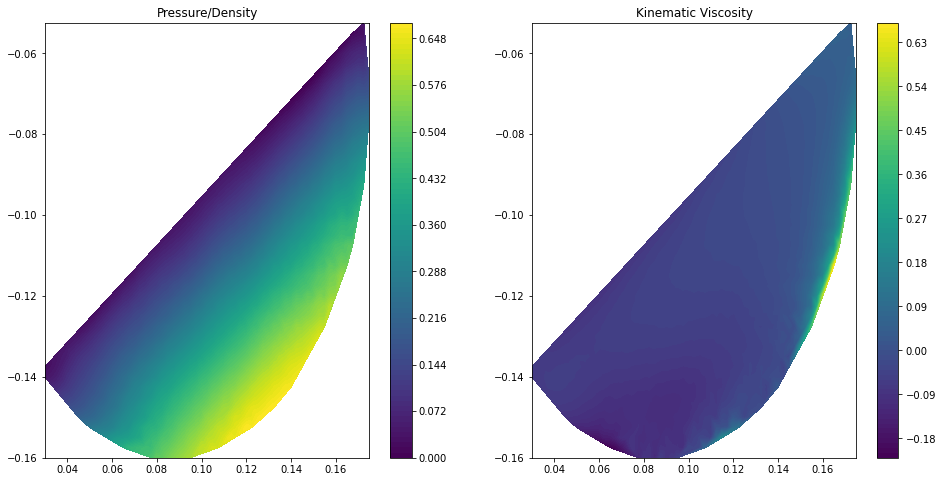

In [519]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.tricontourf(X_interior[:,0],X_interior[:,1],LS_solution[0][N:2*N,0],levels=100)
plt.title('Pressure/Density')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.tricontourf(X_interior[:,0],X_interior[:,1],LS_solution[0][0:N,0],levels=100)
plt.title('Kinematic Viscosity')
plt.colorbar()

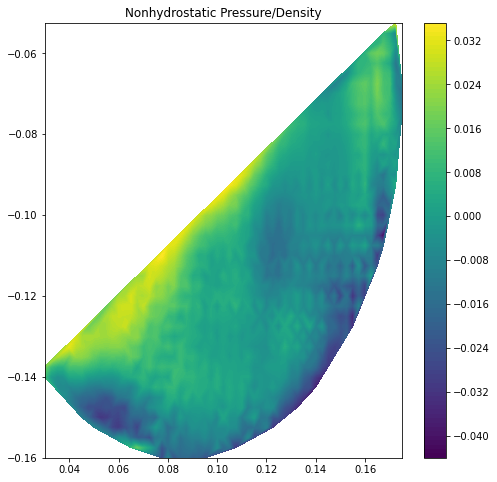

In [520]:
#non hydrostatic pressure:
plt.figure(figsize=(8,8))
plt.tricontourf(X_interior[:,0],X_interior[:,1],LS_solution[0][N:2*N,0]-(m*X_interior[:,0] + c - X_interior[:,1])*g,levels=100)
plt.title('Nonhydrostatic Pressure/Density')
plt.colorbar()


Text(0.5, 0, 'Shear Rate')

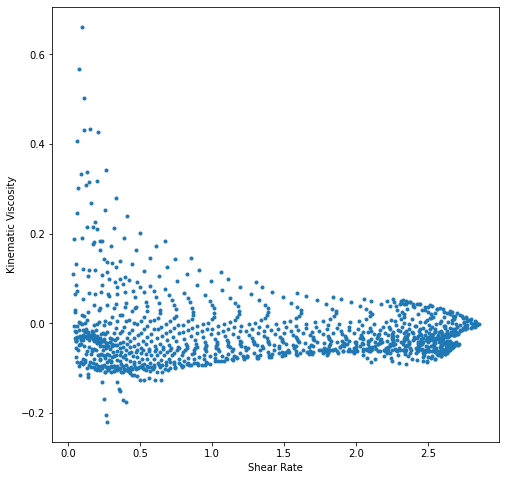

In [521]:
plt.figure(figsize=(8,8))
gamma = 0.5**0.5*(np.diag(dudx)**2 + 0.5*(np.diag(dvdx)+np.diag(dudz))**2 + np.diag(dvdz)**2 )**0.5
plt.plot(gamma,LS_solution[0][0:N,:],'.')
gamma_plot = np.arange(0,5,0.01)
#plt.plot(gamma_plot,0.0025*(gamma_plot+1)**0.5-0.0007,'k')
plt.xlabel('')
plt.ylabel('Kinematic Viscosity')
plt.xlabel('Shear Rate')
#plt.ylim([0,0.001])

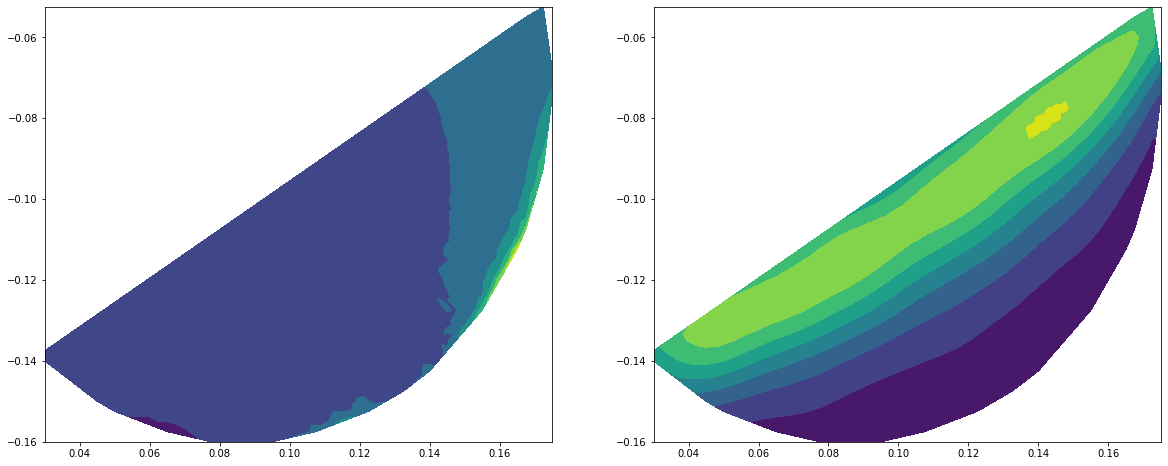

In [522]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.tricontourf(X_interior[:,0],X_interior[:,1],LS_solution[0][0:N,0])

plt.subplot(1, 2, 2)
plt.tricontourf(X_interior[:,0],X_interior[:,1],gamma)

/tmp/ipykernel_1613/551436748.py:2: RuntimeWarning: divide by zero encountered in true_divide
  I = np.sqrt(1700)*0.012*gamma/np.sqrt(LS_solution[0][N:2*N,0]/np.diag(rho))
/tmp/ipykernel_1613/551436748.py:21: RuntimeWarning: divide by zero encountered in true_divide
  muI = mus + (mu2-mus)/(I0/Iplot + 1)


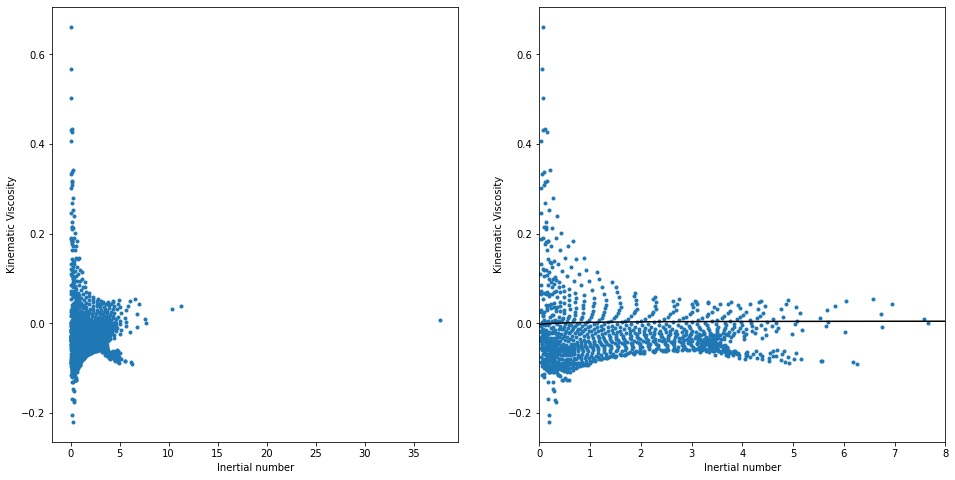

In [523]:
#mu vs I plot:
I = np.sqrt(1700)*0.012*gamma/np.sqrt(LS_solution[0][N:2*N,0]/np.diag(rho))
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(I,(LS_solution[0][0:N,:]),'.')
plt.xlabel('Inertial number')
plt.ylabel('Kinematic Viscosity')

plt.subplot(1, 2, 2)
plt.plot(I,(LS_solution[0][0:N,:]),'.')
plt.xlim([0,8])
plt.xlabel('Inertial number')
plt.ylabel('Kinematic Viscosity')

#fitting mu(I):

Iplot = np.arange(0,15,0.01)
mus = -0.002
mu2 = 0.0055
I0 = 0.67
muI = mus + (mu2-mus)/(I0/Iplot + 1)
plt.plot(Iplot,muI,'k')
